Converted mat data to CSV and imported as arrays.
Inported matplotlib and scipy to create PSDs

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import wave_model as wm
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
from scipy import signal

#velocities are in m/s and the pressure is in decibars (1db = 10**4 Pa)
#convert afterwards by multiplying by 10**8 (conversion squared)
#  
CB_data = np.loadtxt('data/ADV_data_CB_out1.csv',delimiter=',',skiprows=1)
#data order: dn,P,u,v,w
CB_data = CB_data.transpose()

MV_data = np.loadtxt('data/ADV_data_MV_out1.csv',delimiter=',',skiprows=1)
#data order: dn,P,u,v,w
MV_data = MV_data.transpose()
datatypes = ["Pressure","HorizontalU Velocity","HorizontalV Velocity","Vertical Velocity"]
#MV: water depth is 16m
#    data was collected 0.4m above the seafloor (z = -15.6m)
#CB: water depth is 14m
#    data was collected 1.8m below the mean sea surface (z = -1.8m)
# sampling frequency of the instrument is 32Hz.
# time (dn)
# pressure (P)
# horizontal velocity (u & v)
# vertical velocity (w)

1.	Compute and plot the spectrum of pressure, vertical velocity and horizontal velocity (Suu+Svv) for both locations.  Describe the differences between the locations and explain what might cause these differences:

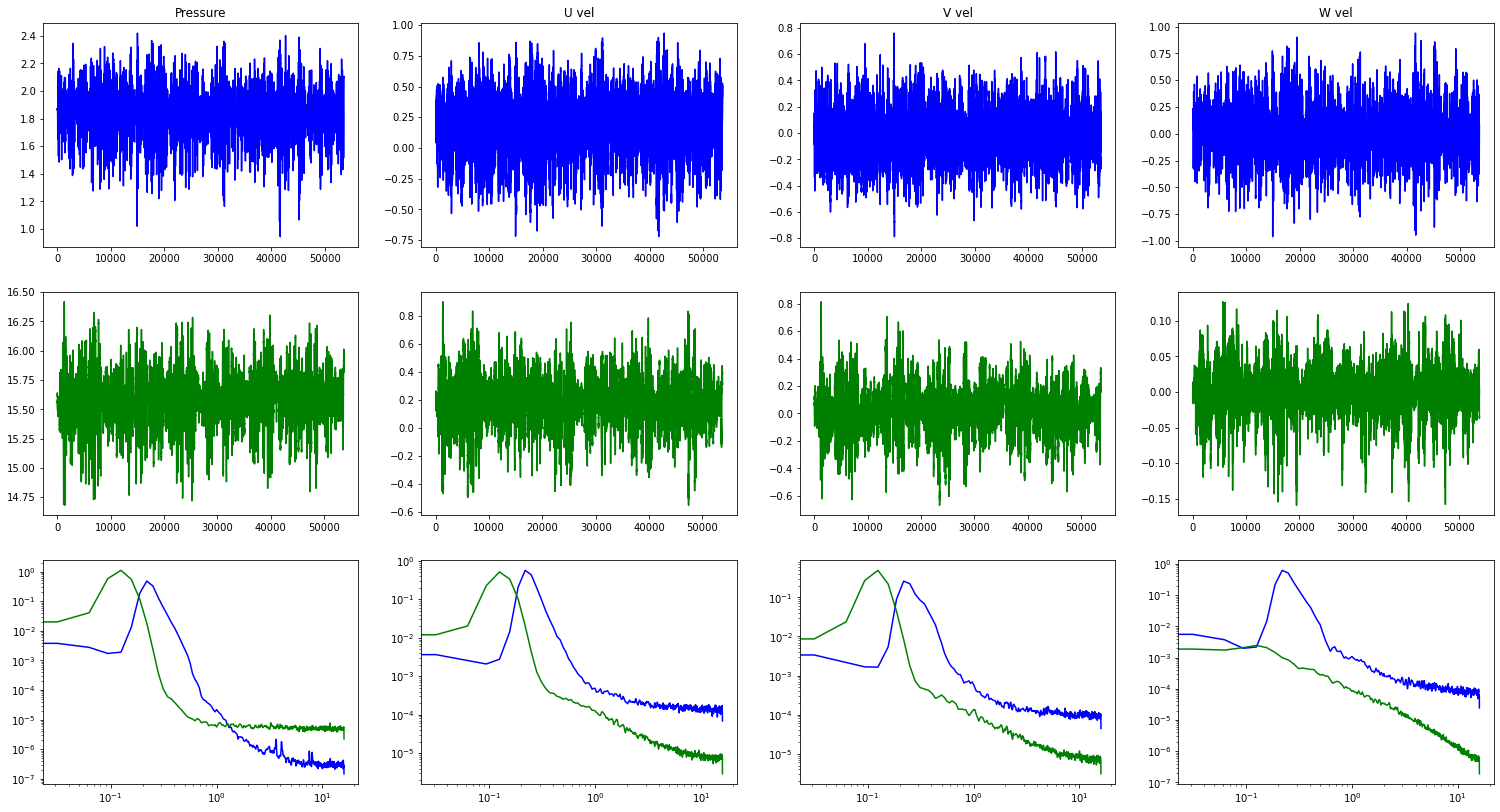

In [2]:
fig, ((ax0,ax2,ax4,ax6),(ax1,ax3,ax5,ax7),(ax8,ax9,ax10,ax11)) = plt.subplots(3, 4,figsize=(26, 14))
i=0
plots = fig.get_axes()
titles = ["Pressure","U vel","V vel","W vel"]#dn,P,u,v,w
for i in range(4):
    plots[i].plot(CB_data[i+1],color="blue")
    #plots[i+4].psd(CB_data[i+1], NFFT=150, Fs=32, window=mlab.window_none, pad_to=512, noverlap=75,scale_by_freq=True)
    plots[i+4].plot(MV_data[i+1],color="green")
    f, Pxx_den = signal.welch(CB_data[i+1], 32, nperseg=1024)
    plots[i+8].loglog(f, Pxx_den,color="blue")
    
    f, Pxx_den = signal.welch(MV_data[i+1], 32, nperseg=1024)
    plots[i+8].loglog(f, Pxx_den,color="green")

    plots[i].set_title(titles[i])

"""
ax1.set_title('Welch Settings:')
ax1.set_ylabel('')  # overwrite the y-label added by `psd`
ax1.grid(True)
#ax7.set_xlim(-10, 20)
"""
plt.show()

2.	Using the relationships for the pressure spectrum (Spp) and the horizontal velocity spectrum (Suu+Svv) given in class (Lecture Notes 9), derive an expression for the Spp in terms of Suu+Svv.  

Apply this expression at both locations and compare it to the observed pressure spectrum.  Are they consistent? Briefly summarize.

<ipython-input-20-5f2bef97c82a>:3: RuntimeWarning: divide by zero encountered in double_scalars
  return uu / (f**2)  / 100
<ipython-input-20-5f2bef97c82a>:3: RuntimeWarning: divide by zero encountered in double_scalars
  return uu / (f**2)  / 100


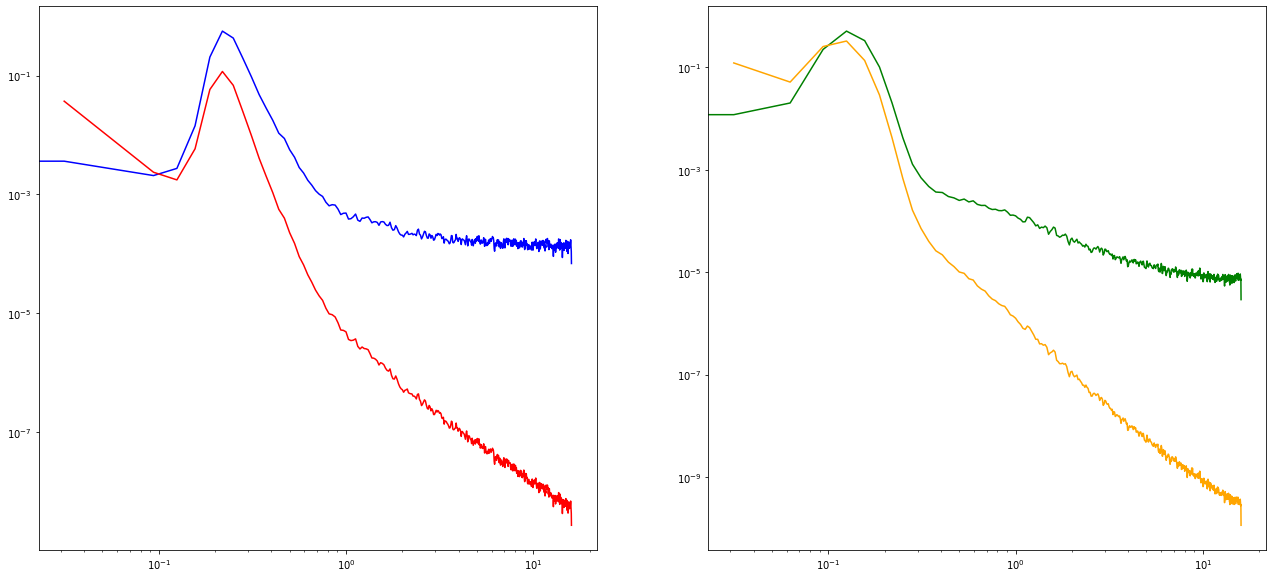

In [20]:
#derive Spp from Suu and Svv
def uu_to_pp(uu,f):
    return uu / (f**2)  / 100
    """
    amplitude = energy --- frequency = wave period (convert from htz to seconds)  so convert f(freq) to w omega which is wave 
    freq 1/period
    omega = 2*pi * period
    pxx is energy = proportionate to ada**2
    W**2
    f=1/t
    w=2pi/t

    W**2 = (aw)**2  
    """


fig, (ax0,ax1) = plt.subplots(1, 2,figsize=(22, 10))
i=0
plots = fig.get_axes()
titles = ["Pressure","U vel","V vel","W vel"]#dn,P,u,v,w
    
f, CB_Pxx_den = signal.welch(CB_data[2], 32, nperseg=1024)
plots[0].loglog(f, CB_Pxx_den,color="blue")

f, MV_Pxx_den = signal.welch(MV_data[2], 32, nperseg=1024)
plots[1].loglog(f, MV_Pxx_den,color="green")

pp_CB_Pxx_den = CB_Pxx_den
for i in range(len(Pxx_den)):
    pp_CB_Pxx_den[i] = uu_to_pp(CB_Pxx_den[i],f[i])

plots[0].loglog(f, pp_CB_Pxx_den,color="red")

pp_MV_Pxx_den = MV_Pxx_den
for i in range(len(Pxx_den)):
    pp_MV_Pxx_den[i] = uu_to_pp(MV_Pxx_den[i],f[i])
plots[1].loglog(f, pp_MV_Pxx_den,color="orange")

"""
ax1.set_title('Welch Settings:')
ax1.set_ylabel('')  # overwrite the y-label added by `psd`
ax1.grid(True)
#ax7.set_xlim(-10, 20)
"""
plt.show()

3.	Derive the relationship between the pressure spectrum (Spp) and the vertical velocity spectrum (Sww).  Compare the observed pressure spectrum to the relationship derived from vertical velocity. 

4. 	Explain how the pressure spectra under surface waves would change depending on the depth beneath the surface where the measurement is made.  Provide a quantitative example to illustrate this.

5.	Calculate the significant wave height (Hs) and wave period (T) from the pressure spectrum for each data set.  For the calculation of Hs assume that the pressure signal is only driven by the hydrostatic response to the sea surface and that 1 decibar = 1m of sea level.  Compare these estimates to estimates made from zero crossing with the same assumptions.   

up crossing is whenever amplitude 